Loading and preparing base data...
Sorting data chronologically by commit_date...


C:\Users\pradishan\AppData\Local\Temp\ipykernel_10820\2120650468.py:19: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["commit_date"] = pd.to_datetime(df["commit_date"])


Data sorted successfully.

Normalizing embedding vectors...
Vectors normalized.

Performing PCA to reduce dimensions to 51...
PCA complete. New feature shape: (12595, 177)

Splitting data chronologically (80% train, 20% test)...
Training set size: 10076
Test set size: 2519

Training XGBoost classifier...


c:\Users\pradishan\code\wso2-AI-Tool\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training complete.

Evaluating the model on the chronological test set...
Accuracy: 0.3855

Classification Report:
              precision    recall  f1-score   support

   Not a Bug       0.93      0.31      0.47      2188
         Bug       0.16      0.85      0.27       331

    accuracy                           0.39      2519
   macro avg       0.55      0.58      0.37      2519
weighted avg       0.83      0.39      0.44      2519


Generating confusion matrix...


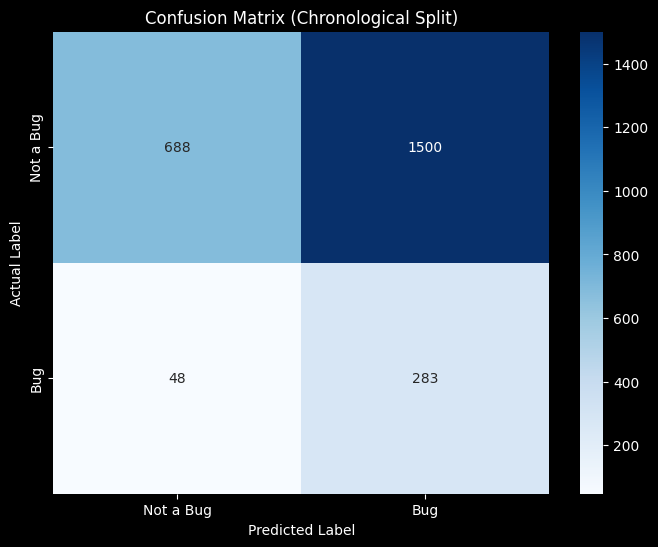


Chronological split validation process is complete.


In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

# --- 1. Load and Prepare Data Chronologically ---
print("Loading and preparing base data...")
# Load the original dataset
df = pd.read_csv("data/final_dataset_with_embeddings.csv")
df.dropna(subset=['commit_hash', 'is_bug_introducing'], inplace=True)

# Sort the entire DataFrame by date BEFORE feature extraction
print("Sorting data chronologically by commit_date...")
df["commit_date"] = pd.to_datetime(df["commit_date"])
df.sort_values(by="commit_date", inplace=True)
df.reset_index(drop=True, inplace=True)
print("Data sorted successfully.")

# Separate the data into features (X), labels (y), and metadata
embedding_cols = [col for col in df.columns if col.startswith('emb_')]
X = df[embedding_cols].values
y = df['is_bug_introducing'].values

# --- 2. Normalize and Apply PCA (as before) ---
print("\nNormalizing embedding vectors...")
normalizer = Normalizer(norm='l2')
X_normalized = normalizer.fit_transform(X)
print("Vectors normalized.")

print("\nPerforming PCA to reduce dimensions to 51...")
pca = PCA(n_components=177, random_state=42)
X_pca = pca.fit_transform(X_normalized)
print(f"PCA complete. New feature shape: {X_pca.shape}")


# --- 3. Split Data Chronologically ---
print("\nSplitting data chronologically (80% train, 20% test)...")
split_point = int(len(X_pca) * 0.80)
X_train, X_test = X_pca[:split_point], X_pca[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# --- 4. Train and Evaluate XGBoost Classifier (as before) ---
print("\nTraining XGBoost classifier...")
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_classifier.fit(X_train, y_train)
print("Training complete.")

print("\nEvaluating the model on the chronological test set...")
y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not a Bug', 'Bug']))

print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not a Bug', 'Bug'],
            yticklabels=['Not a Bug', 'Bug'])
plt.title('Confusion Matrix (Chronological Split)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nChronological split validation process is complete.")